# Szeregi czasowe

Zadanie z szeregów czasowych na podstawie wykładu Kamila Książeka

## Importy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

## Data preprocessing

Wczytamy zbiór danych dotyczący zużycia energii w megawatach [MW] zanotowanego przez firmę Commonwealth Edison (ComEd) w Illinois. Zbiór zawiera dane od stycznia 2011 roku do sierpnia 2018 roku.

In [2]:
dataframe = pd.read_csv("./resources/COMED_hourly.csv")
dataframe = dataframe.set_index("Datetime")
dataframe.index = pd.to_datetime(dataframe.index)
# Dane w wielu miejscach nie są uporządkowane, co może generować błędy.
# Bardzo ważny punkt analizy szeregów czasowych!
dataframe = dataframe.sort_index()
print(dataframe.head())

                     COMED_MW
Datetime                     
2011-01-01 01:00:00    9631.0
2011-01-01 02:00:00    9273.0
2011-01-01 03:00:00    9011.0
2011-01-01 04:00:00    8741.0
2011-01-01 05:00:00    8694.0


Przyjrzyjmy się teraz danym, dla których będziemy chcieli dokonać predykcji.

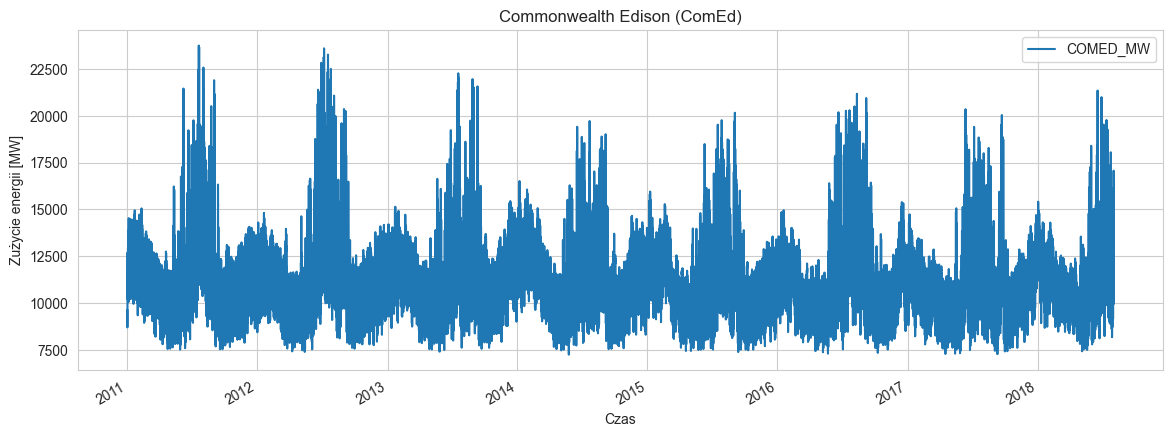

In [3]:
sns.set_style("whitegrid")
dataframe.plot(figsize=(14, 5),
               title="Zużycie energii w MW")
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.title("Commonwealth Edison (ComEd)")
plt.show()

Podzielmy dane na zbiór treningowy oraz testowy. Dane do końca 2016 roku będą stanowiły zbiór treningowy, zaś dane od 1 stycznia 2017 roku będą nalezały do zbioru testowego.

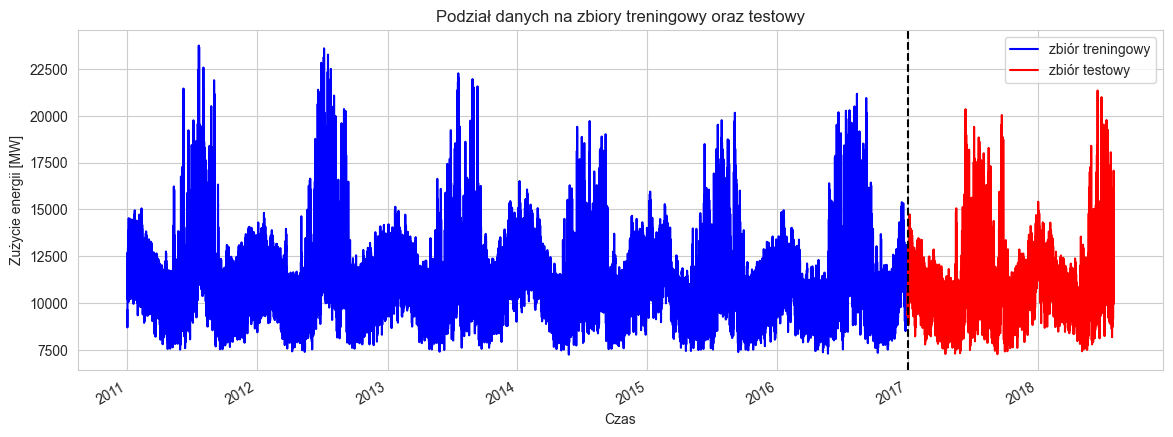

In [4]:
train_set = dataframe.loc[
    dataframe.index < "01-01-2017"
]
test_set = dataframe.loc[
    dataframe.index >= "01-01-2017"
]

fig, ax = plt.subplots(figsize=(14, 5))
train_set.plot(
    ax=ax, label='zbiór treningowy',
    title="Podział danych na zbiory treningowy oraz testowy",
    color='blue'
)
test_set.plot(
    ax=ax, label="zbiór testowy",
    color='red'
)
ax.axvline('01-01-2017', color='black',
           linestyle='dashed')
ax.legend(['zbiór treningowy', 'zbiór testowy'])
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.show()

Przyjrzyjmy się teraz bliżej danym z wybranego tygodnia lutego 2012 roku.

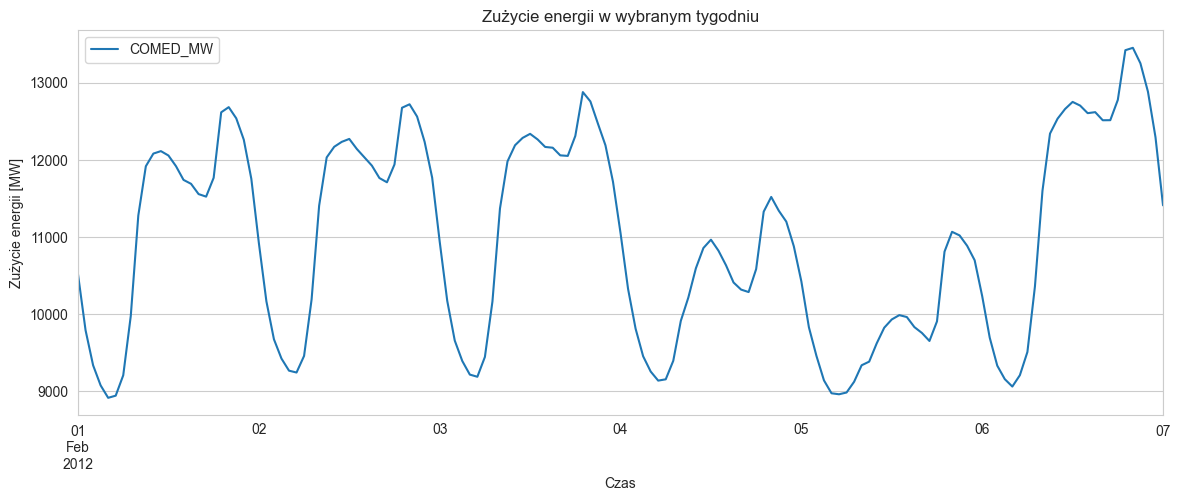

In [5]:
# Prezentacja danych dla wybranego tygodnia pomiarów
fig, ax = plt.subplots(figsize=(14, 5))
selected_week_of_data = dataframe.loc[
    (dataframe.index >= "2012-02-01") &
    (dataframe.index <= "2012-02-07")
]
selected_week_of_data.plot(
    figsize=(14, 5),
    ax=ax,
    title="Zużycie energii w wybranym tygodniu"
)
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.show()

Stwórzmy teraz funkcję przygotowującą zbiór danych na wejście do sieci neuronowej. Będą to zarówno dane wejściowe jak i cel do przewidzenia wraz z odpowiadającym znacznikom czasowym.

In [6]:
def prepare_dataset(data, indices, time_horizon, prediction_window):
    """
    Przygotujemy zbiór danych, który będzie zawierał dane o określonym
    horyzoncie czasowym. Do przewidzenia będzie *prediction_window* kolejnych
    wartości i będą one zawarte w zbiorze wartości docelowych.

    Argumenty:
    ----
       *data*: (Numpy array) zawiera kolejne wartości szeregu czasowego
       *indices*: (Pandas DatetimeIndex) zawiera znaczniki czasowe dla kolejnych
                  wartości zawartych w tablicy *data*
       *time_horizon*: (int) określa dostępny horyzont czasowy poprzednich wartości
                       do przewidzenia kolejnych
       *prediction_window*: (int) określa horyzont czasowy do przewidywania
    """
    X, y, target_timestamps = [], [], []
    for i in range(len(data) - time_horizon - prediction_window + 1):
        features = data[i : (i + time_horizon)]
        target = data[(i + time_horizon):(i + time_horizon + prediction_window)]
        timestamps = indices[(i + time_horizon):(i + time_horizon + prediction_window)]
        X.append(features)
        y.append(target)
        target_timestamps.append(timestamps)
    X = torch.tensor(X).to(torch.float32).reshape(-1, time_horizon, 1)
    y = torch.tensor(y).to(torch.float32).reshape(-1, prediction_window)
    return X, y, target_timestamps

Sieć podczas treningu będzie mieć do dyspozycji dane z kolejnych 24 godzin, a będzie miała przewidzieć zużycie energii w kolejnych 6 godzinach.

In [7]:
time_horizon = 24  # 24 kolejne odczyty odpowiadające godzinom
prediction_window = 6
X_train, y_train, train_timestamps = prepare_dataset(
    list(train_set["COMED_MW"].values),
    train_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)
X_test, y_test, test_timestamps = prepare_dataset(
    list(test_set["COMED_MW"].values),
    test_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)

Teraz należy dokonać przetworzenia wstępnego danych. Należy to uczynić jedynie na danych treningowych, aby uniknąć wycieku danych ze zbioru testowego. Zastosujemy standaryzację. Ustalone parametry zastosujemy zarówno dla danych treningowych jak i testowych.

In [8]:
mean = X_train.mean()
std_deviation = X_train.std()
X_train = (X_train - mean) / std_deviation
X_test = (X_test - mean) / std_deviation
y_train = (y_train - mean) / std_deviation
y_test = (y_test - mean) / std_deviation

## Model

Stworzymy teraz szkielet modelu sieci opartej na komórkach LSTM. Na koniec wstawimy jedną warstwę liniową, która będzie dokonywać predykcji wyników.

In [9]:
class PredictionModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM = nn.LSTM(input_size=input_size,  # liczba spodziewanych cech
                            hidden_size=self.hidden_size,  # liczba cech w "hidden state"
                            num_layers=self.num_layers,  # liczba warstw rekurencyjnych
                            batch_first=True)  # wejście będzie miało mieć kształt
                            # (batch, ciąg, cechy)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        # h0 i c0 reprezentują początkowe wartości dla "hidden state" oraz "cell
        # state". Nie są to trenowalne parametry, czyli nie są one aktualizowane
        # podczas wstecznej propagacji. 
        # "Hidden state" działa jak rodzaj pamięci, przechowując informacje z
        # poprzednich kroków czasowych. Na początku potrzebuje jednak jakichś
        # wartości początkowych. Po przejściu całej sekwencji zawiera wartościowe
        # informacje dotyczące tej sekwencji.
        # "Cell state" jest innym rodzajem pamięci, ale jest mniej podatny na problem
        # zanikających gradientów niż "hidden state". Podobnie jak h0, potrzebuje
        # pewnych początkowych wartości.
        # Różne sekwencje mogą potrzebować innych punktów początkowych, a inicjalizacja
        # zerami pozwala LSTMowi na dynamiczną adaptację wartości.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.LSTM(x, (h0, c0))
        # Weźmy ostatnie wyjście z LSTMa, gdyż zawiera ono najbardziej istotne informacje
        # powstałe po przejściu całej sekwencji wejściowej. Normalnie, wyjście LSTMa ma
        # rozmiar (rozmiar batcha, długość sekwencji wejściowej, wielkość stanu ukrytego).
        # Istnieje alternatywne, choć rzadziej stosowane rozwiązanie, żeby do warstwy
        # liniowej wrzucać całe wyjście LSTMa, ale np. po zastosowaniu metody average
        # pooling.
        x = self.linear(x[:, -1, :])
        return x

Jeśli mamy taką możliwość, wytrenujmy model z użyciem GPU.

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f'Urządzenie: {device}')

Urządzenie: mps


Przygotujmy funkcję do ustawienia ziarna generatora liczb pseudolosowych, aby zapewnić deterministyczne wyniki treningu sieci. 

In [11]:
def set_seed(value):
    """
    Set deterministic results according to the given value
    (including random, numpy and torch libraries)
    """
    np.random.seed(value)
    torch.manual_seed(value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**UWAGA!!** Poniższy trening jest treningiem poglądowym. Aby uzyskać optymalne wyniki, należałoby dostroić hiperparametry oraz dodać kilka niezbędnych elementów, w szczególności wydzielić zbiór walidacyjny ze zbioru treningowego i na jego podstawie dokonywać wczesnego zatrzymywania treningu (ang. *early stopping*). Poza tym, należałoby ostrożnie wybrać współczynnik uczenia (ang. *learning rate*), rozmiar sekwencji wyjściowej (*output_size*), ilość próbek wchodzących jednocześnie do sieci (*batch_size*) czy wybrać maksymalną liczbę epok treningowych.

Na koniec zapiszemy do pliku wytrenowany model.

In [12]:
def simple_train(model, optimizer, regression_loss, train_dataloader, number_of_epochs = 300, model_name='simple_train_LSTM_model'):
    for epoch in range(number_of_epochs):
        model.train()
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prediction = model(X_batch)
            loss = regression_loss(prediction, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            train_prediction = model(X_batch)
            train_RMSE = np.sqrt(regression_loss(train_prediction, y_batch).cpu().detach())
        print(f"Epoka: {epoch}, treningowe RMSE: {train_RMSE}.")
    torch.save(model.state_dict(), model_name)

In [13]:
set_seed(5)
model = PredictionModel(input_size=1, output_size=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
model_name = 'simple_train_LSTM_model'
simple_train(model, optimizer, regression_loss, train_dataloader, number_of_epochs=number_of_epochs, model_name=model_name)

Epoka: 0, treningowe RMSE: 0.2161998748779297.
Epoka: 10, treningowe RMSE: 0.11787676811218262.
Epoka: 20, treningowe RMSE: 0.09576931595802307.
Epoka: 30, treningowe RMSE: 0.15448519587516785.
Epoka: 40, treningowe RMSE: 0.08319956064224243.
Epoka: 50, treningowe RMSE: 0.10139677673578262.
Epoka: 60, treningowe RMSE: 0.08932632207870483.
Epoka: 70, treningowe RMSE: 0.0688265785574913.
Epoka: 80, treningowe RMSE: 0.06433604657649994.
Epoka: 90, treningowe RMSE: 0.07069484889507294.
Epoka: 100, treningowe RMSE: 0.06069144606590271.
Epoka: 110, treningowe RMSE: 0.07114288955926895.
Epoka: 120, treningowe RMSE: 0.0629480704665184.
Epoka: 130, treningowe RMSE: 0.0696251168847084.
Epoka: 140, treningowe RMSE: 0.06071893870830536.
Epoka: 150, treningowe RMSE: 0.05227958783507347.
Epoka: 160, treningowe RMSE: 0.07314904779195786.
Epoka: 170, treningowe RMSE: 0.06226272135972977.
Epoka: 180, treningowe RMSE: 0.05549544468522072.
Epoka: 190, treningowe RMSE: 0.04456573724746704.
Epoka: 200, tre

Wczytajmy teraz nauczony wcześniej model.

In [14]:
model = PredictionModel(input_size=1, output_size=6).to(device)
model.load_state_dict(torch.load(model_name, weights_only=True))
model.eval()


PredictionModel(
  (LSTM): LSTM(1, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=6, bias=True)
)

In [15]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.18477240204811096.


Przygotujmy teraz funkcję dokonującą ostatecznego zestawienia wyników.

In [16]:
def aggregate_predictions(predictions, timestamps_list):
    """
    Agreguje predykcje dla wielu tablic Numpy z różnymi ramkami czasowymi,
    uśredniając je dla takich samych ramek czasowych.

    Argumenty:
    ---------
        *predictions*: (lista zawierająca Numpy array). Każda tablica zawiera
                       M predykcji, każda dla innej ramki czasowej.
        *timestamps_list*: lista obiektów typu pandas.DatetimeIndex lub obiektów typu
                           string lub datetime, reprezentujących ramki czasowe
                           odpowiadające predykcjom w każdej z tablic.

    Wyjście:
    --------
        Pandas DataFrame zawierający zagregowane predykcje, jeden wiersz dla jednej
        ramki czasowej. Zwraca None, jeśli nie będą zachowane rozmiary na wejściu.
    """

    if len(predictions) != len(timestamps_list):
        print("Błąd: liczba tablic z predykcjami oraz zawierających ramki czasowe "
              "muszą być takie same.")
        return None

    # Słownik, który będzie przechowywać zakumulowane predykcje dla ramek czasowych
    timestamp_data = {}

    for i, pred_array in enumerate(predictions):
        timestamps = timestamps_list[i]
        if not isinstance(timestamps, pd.DatetimeIndex):
            timestamps = pd.DatetimeIndex(timestamps)

        for j, prediction in enumerate(pred_array):
            timestamp = timestamps[j]
            if timestamp not in timestamp_data:
                timestamp_data[timestamp] = []
            timestamp_data[timestamp].append(prediction)

    # Stwórzmy obiekt typu Pandas DataFrame i obliczmy średnie dla każdej ramki czasowej.

    df = pd.DataFrame({'timestamp': list(timestamp_data.keys()),
                       'predictions': list(timestamp_data.values())})
    df['prediction_mean'] = df['predictions'].apply(np.mean)
    df = df.drop(columns=['predictions'])
    return df


In [17]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10078.882812
1     2017-01-02 01:00:00      9554.095703
2     2017-01-02 02:00:00      9215.410156
3     2017-01-02 03:00:00      8976.099609
4     2017-01-02 04:00:00      8863.223633
...                   ...              ...
13866 2018-08-02 20:00:00     16079.112305
13867 2018-08-02 21:00:00     15638.804688
13868 2018-08-02 22:00:00     15307.690430
13869 2018-08-02 23:00:00     14604.818359
13870 2018-08-03 00:00:00     13470.205078

[13871 rows x 2 columns]


Porównajmy teraz predykcje sieci z rzeczywistymi wartościami.

In [18]:
def visualize_comparison(pred, gt):
    fig, ax = plt.subplots(figsize=(20, 5))
    pred.plot(
        ax=ax, label='predykcje',
        x="timestamp",
        y="prediction_mean",
        title="Porównanie predykcji z rzeczywistymi wartościami szeregu",
        color='blue',
        linewidth=1
    )
    gt.plot(
        ax=ax, label="rzeczywiste wartości",
        color='red',
        linewidth=1,
    )
    ax.legend(['predykcje', 'rzeczywiste wartości'])
    plt.xlabel("Czas")
    plt.ylabel("Zużycie energii [MW]")
    plt.show()

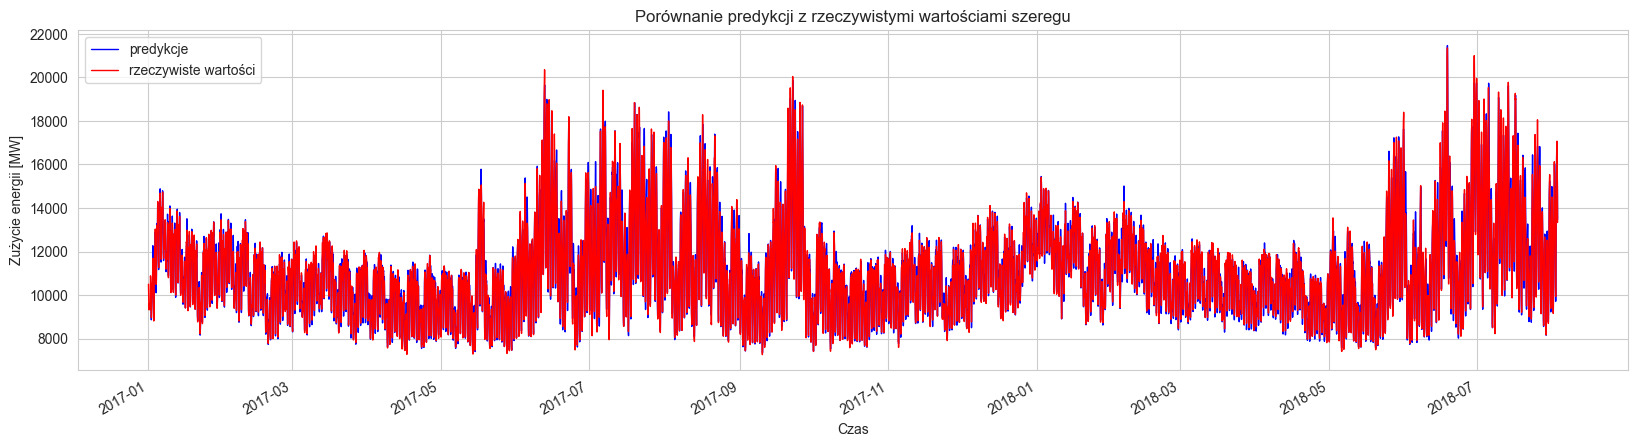

In [19]:
visualize_comparison(resulted_dataframe, test_set)

### Zadanie 1. Data Preparation (1 pkt.)

Podziel dane na train, validation i test sety

In [24]:
train_set = dataframe.loc[
    dataframe.index < "01-01-2016"
]
val_set = dataframe.loc[
    (dataframe.index >= "01-01-2016") & (dataframe.index < "01-01-2017")
]
test_set = dataframe.loc[
    dataframe.index >= "01-01-2017"
]


time_horizon = 24  # 24 kolejne odczyty odpowiadające godzinom
prediction_window = 6
X_train, y_train, train_timestamps = prepare_dataset(
    list(train_set["COMED_MW"].values),
    train_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)
X_val, y_val, val_timestamps = prepare_dataset(
    list(val_set["COMED_MW"].values),
    val_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)
X_test, y_test, test_timestamps = prepare_dataset(
    list(test_set["COMED_MW"].values),
    test_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)
mean = X_train.mean()
std_deviation = X_train.std()
X_train = (X_train - mean) / std_deviation
X_test = (X_test - mean) / std_deviation
X_val = (X_val - mean) / std_deviation
y_val = (y_val - mean) / std_deviation
y_train = (y_train - mean) / std_deviation
y_test = (y_test - mean) / std_deviation

### Zadanie 2. Train function (1 pkt.)


Napisz funkcję dla trenowania modelu z walidacją

In [25]:
def train(model, optimizer, regression_loss, train_dataloader, val_dataloader, number_of_epochs=300, model_name='my_model'):
    for epoch in range(number_of_epochs):
        model.train()
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prediction = model(X_batch)
            loss = regression_loss(prediction, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Training evaluation
                train_losses = []
                for X_batch, y_batch in train_dataloader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    prediction = model(X_batch)
                    train_loss = regression_loss(prediction, y_batch).cpu().detach()
                    train_losses.append(train_loss.item())
                train_RMSE = np.sqrt(np.mean(train_losses))

                # Validation evaluation
                val_losses = []
                for X_batch, y_batch in val_dataloader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    prediction = model(X_batch)
                    val_loss = regression_loss(prediction, y_batch).cpu().detach()
                    val_losses.append(val_loss.item())
                val_RMSE = np.sqrt(np.mean(val_losses))

            print(f"Epoka: {epoch}, treningowe RMSE: {train_RMSE}, walidacyjne RMSE: {val_RMSE}.")

    torch.save(model.state_dict(), model_name)


### Zadanie 3. Porównanie modeli rekurencyjnych (6 pkt.)


Porównaj rózne achitektury modeli rekurencyjnych dostępnych w `torch.nn` (`torch.nn.RNN`, `torch.nn.GRU`,`torch.nn.LSTM`) oraz wcześniej poznanych architektur (`Linear`, `MLP`, `CNN`).

Note: Oprócz modułu rekurencyjnego, model ma zawierać także inne warstwy (patrz przykład z `PredictionModel` powyżej)

Wytrenuj każdy z nich funkcją `train` z poprzedniego zadania i wizualizuj wyniki

In [26]:
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size=input_size, 
                          hidden_size=self.hidden_size, 
                          num_layers=self.num_layers, 
                          batch_first=True)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.RNN(x, h0)
        x = self.linear(x[:, -1, :])
        return x

In [27]:
class GRUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.GRU = nn.GRU(input_size=input_size, 
                          hidden_size=self.hidden_size, 
                          num_layers=self.num_layers, 
                          batch_first=True)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.GRU(x, h0)
        x = self.linear(x[:, -1, :])
        return x


In [48]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1).to(device)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters=32, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.fc = nn.Linear(num_filters, output_size)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch, channels, sequence_length)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # Global average pooling
        x = self.fc(x)
        return x

In [32]:
model = RNNModel(input_size=1, output_size=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
val_dataloader = DataLoader(
    TensorDataset(
        X_val, y_val
    ),
    shuffle=True,
    batch_size=64,
)
train(
    model=model, 
    optimizer=optimizer, 
    regression_loss=regression_loss, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    number_of_epochs=80, 
    model_name='RNNModel'
)

Epoka: 0, treningowe RMSE: 0.2432754619100875, walidacyjne RMSE: 0.23990110940286144.
Epoka: 10, treningowe RMSE: 0.16835410873910817, walidacyjne RMSE: 0.17923205040826903.
Epoka: 20, treningowe RMSE: 0.1574570511750887, walidacyjne RMSE: 0.173586430503455.
Epoka: 30, treningowe RMSE: 0.15420006084384577, walidacyjne RMSE: 0.16797529320995316.
Epoka: 40, treningowe RMSE: 0.15120268267594003, walidacyjne RMSE: 0.17478866269973947.
Epoka: 50, treningowe RMSE: 0.13904202775176236, walidacyjne RMSE: 0.1627850008355329.
Epoka: 60, treningowe RMSE: 0.1468270394209289, walidacyjne RMSE: 0.18025974980548737.
Epoka: 70, treningowe RMSE: 0.13789928454384912, walidacyjne RMSE: 0.16622481239424886.


In [33]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.17963534593582153.


In [34]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10159.295898
1     2017-01-02 01:00:00      9703.881836
2     2017-01-02 02:00:00      9390.352539
3     2017-01-02 03:00:00      9123.750000
4     2017-01-02 04:00:00      8988.553711
...                   ...              ...
13866 2018-08-02 20:00:00     16278.546875
13867 2018-08-02 21:00:00     15677.449219
13868 2018-08-02 22:00:00     15306.577148
13869 2018-08-02 23:00:00     14819.197266
13870 2018-08-03 00:00:00     13632.283203

[13871 rows x 2 columns]


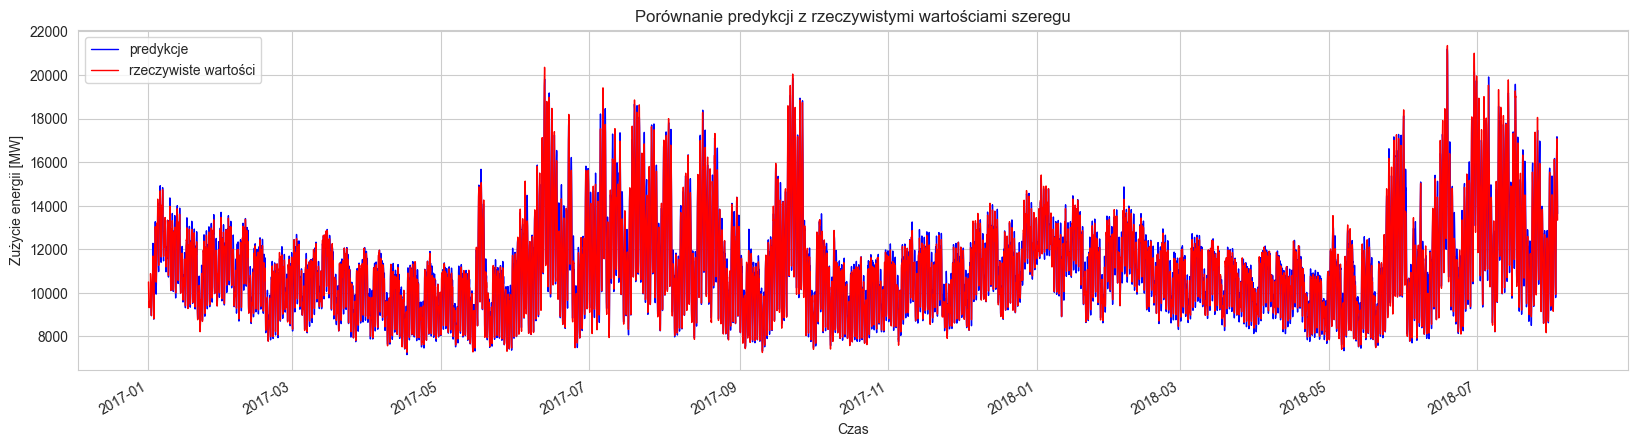

In [36]:
visualize_comparison(resulted_dataframe, test_set)

In [37]:
model = GRUModel(input_size=1, output_size=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
val_dataloader = DataLoader(
    TensorDataset(
        X_val, y_val
    ),
    shuffle=True,
    batch_size=64,
)
train(
    model=model, 
    optimizer=optimizer, 
    regression_loss=regression_loss, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    number_of_epochs=80, 
    model_name='GRUModel'
)

Epoka: 0, treningowe RMSE: 0.24314610446233914, walidacyjne RMSE: 0.24284416914649237.
Epoka: 10, treningowe RMSE: 0.15991196099134833, walidacyjne RMSE: 0.18151357268094037.
Epoka: 20, treningowe RMSE: 0.13901782308257932, walidacyjne RMSE: 0.1691676052688622.
Epoka: 30, treningowe RMSE: 0.12714120515126423, walidacyjne RMSE: 0.16259263492176662.
Epoka: 40, treningowe RMSE: 0.11691455905253485, walidacyjne RMSE: 0.1710918680912451.
Epoka: 50, treningowe RMSE: 0.11176871611222887, walidacyjne RMSE: 0.1703838999700497.
Epoka: 60, treningowe RMSE: 0.12784753511328073, walidacyjne RMSE: 0.17482052009832055.
Epoka: 70, treningowe RMSE: 0.09564753403773164, walidacyjne RMSE: 0.17908929754928415.


In [38]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.1828872263431549.


In [39]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10095.263672
1     2017-01-02 01:00:00      9642.324219
2     2017-01-02 02:00:00      9328.518555
3     2017-01-02 03:00:00      9133.024414
4     2017-01-02 04:00:00      8988.658203
...                   ...              ...
13866 2018-08-02 20:00:00     15892.962891
13867 2018-08-02 21:00:00     15328.377930
13868 2018-08-02 22:00:00     15088.301758
13869 2018-08-02 23:00:00     14562.607422
13870 2018-08-03 00:00:00     13549.216797

[13871 rows x 2 columns]


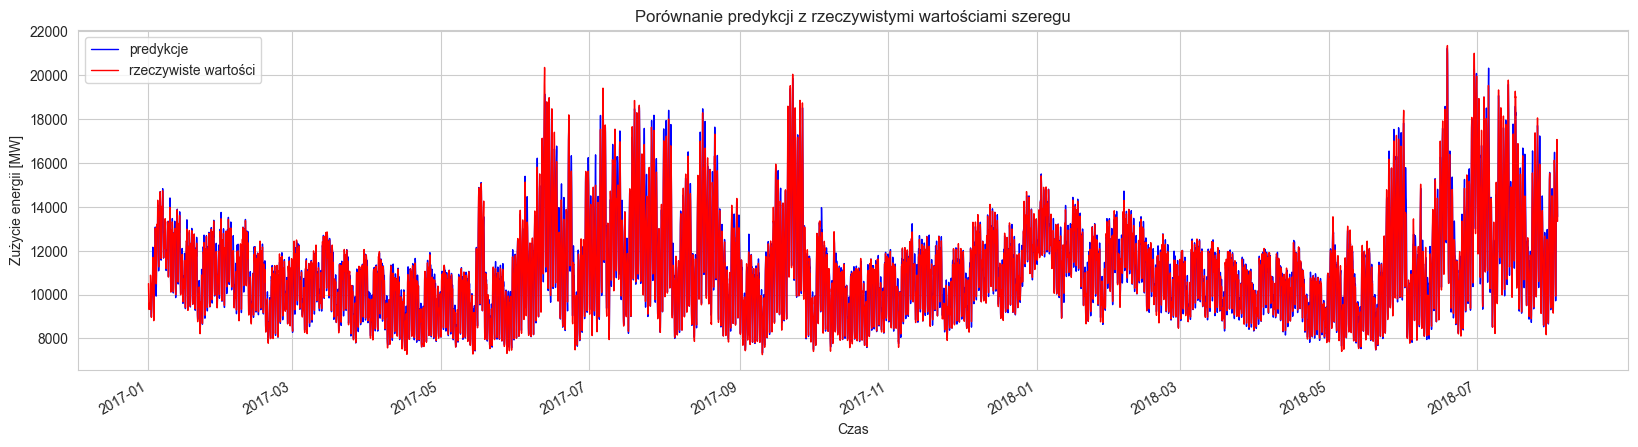

In [40]:
visualize_comparison(resulted_dataframe, test_set)

In [56]:
model = MLPModel(input_size=24, output_size=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
val_dataloader = DataLoader(
    TensorDataset(
        X_val, y_val
    ),
    shuffle=True,
    batch_size=64,
)
train(
    model=model, 
    optimizer=optimizer, 
    regression_loss=regression_loss, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    number_of_epochs=300, 
    model_name='MLPModel'
)

Epoka: 0, treningowe RMSE: 0.22746696754507717, walidacyjne RMSE: 0.22644585112045906.
Epoka: 10, treningowe RMSE: 0.20436181496414793, walidacyjne RMSE: 0.20704958692917916.
Epoka: 20, treningowe RMSE: 0.1877240768081473, walidacyjne RMSE: 0.19038630781619428.
Epoka: 30, treningowe RMSE: 0.20255418484359763, walidacyjne RMSE: 0.20385709247590011.
Epoka: 40, treningowe RMSE: 0.19213763496687275, walidacyjne RMSE: 0.19662020510781386.
Epoka: 50, treningowe RMSE: 0.1920244962610319, walidacyjne RMSE: 0.19511614441666866.
Epoka: 60, treningowe RMSE: 0.18452538643062955, walidacyjne RMSE: 0.18772730763139853.
Epoka: 70, treningowe RMSE: 0.1892223388759059, walidacyjne RMSE: 0.19265199351883572.
Epoka: 80, treningowe RMSE: 0.19057015193264748, walidacyjne RMSE: 0.19486905932937273.
Epoka: 90, treningowe RMSE: 0.19028549093929326, walidacyjne RMSE: 0.19500993175429357.
Epoka: 100, treningowe RMSE: 0.18541393660897687, walidacyjne RMSE: 0.19095367588246828.
Epoka: 110, treningowe RMSE: 0.1823

In [53]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.16643396019935608.


In [54]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10289.185547
1     2017-01-02 01:00:00      9894.231445
2     2017-01-02 02:00:00      9616.899414
3     2017-01-02 03:00:00      9378.474609
4     2017-01-02 04:00:00      9251.825195
...                   ...              ...
13866 2018-08-02 20:00:00     16418.886719
13867 2018-08-02 21:00:00     15712.735352
13868 2018-08-02 22:00:00     15368.088867
13869 2018-08-02 23:00:00     14923.903320
13870 2018-08-03 00:00:00     13964.003906

[13871 rows x 2 columns]


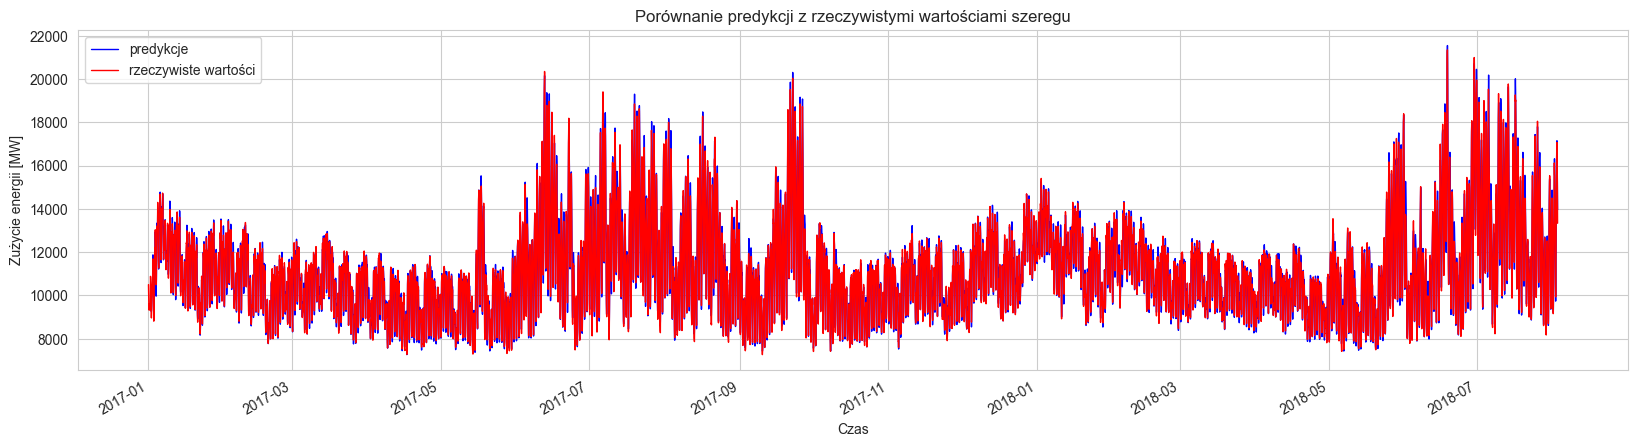

In [55]:
visualize_comparison(resulted_dataframe, test_set)

In [61]:
model = CNNModel(input_size=1, output_size=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
val_dataloader = DataLoader(
    TensorDataset(
        X_val, y_val
    ),
    shuffle=True,
    batch_size=64,
)
train(
    model=model, 
    optimizer=optimizer, 
    regression_loss=regression_loss, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    number_of_epochs=300, 
    model_name='CNNModel'
)

Epoka: 0, treningowe RMSE: 0.6478662262664223, walidacyjne RMSE: 0.6650303872239749.
Epoka: 10, treningowe RMSE: 0.27259143379626544, walidacyjne RMSE: 0.2662289351203845.
Epoka: 20, treningowe RMSE: 0.29022524667987637, walidacyjne RMSE: 0.28613064789035825.
Epoka: 30, treningowe RMSE: 0.2439368634590148, walidacyjne RMSE: 0.2405952250687784.
Epoka: 40, treningowe RMSE: 0.24290293293109974, walidacyjne RMSE: 0.24144324299098147.
Epoka: 50, treningowe RMSE: 0.2395178161396038, walidacyjne RMSE: 0.2385985865894196.
Epoka: 60, treningowe RMSE: 0.2349668437522971, walidacyjne RMSE: 0.2363549362422452.
Epoka: 70, treningowe RMSE: 0.23677335906647712, walidacyjne RMSE: 0.2350140108225762.
Epoka: 80, treningowe RMSE: 0.23067178079354977, walidacyjne RMSE: 0.2311374888359491.
Epoka: 90, treningowe RMSE: 0.23868046143369476, walidacyjne RMSE: 0.2375856761109467.
Epoka: 100, treningowe RMSE: 0.2269373596685544, walidacyjne RMSE: 0.2311185601682271.
Epoka: 110, treningowe RMSE: 0.224108235103895

In [62]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.20641173422336578.


In [63]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10136.082031
1     2017-01-02 01:00:00      9785.943359
2     2017-01-02 02:00:00      9496.999023
3     2017-01-02 03:00:00      9249.125000
4     2017-01-02 04:00:00      9105.032227
...                   ...              ...
13866 2018-08-02 20:00:00     16218.081055
13867 2018-08-02 21:00:00     15520.957031
13868 2018-08-02 22:00:00     14924.257812
13869 2018-08-02 23:00:00     14462.959961
13870 2018-08-03 00:00:00     14019.432617

[13871 rows x 2 columns]


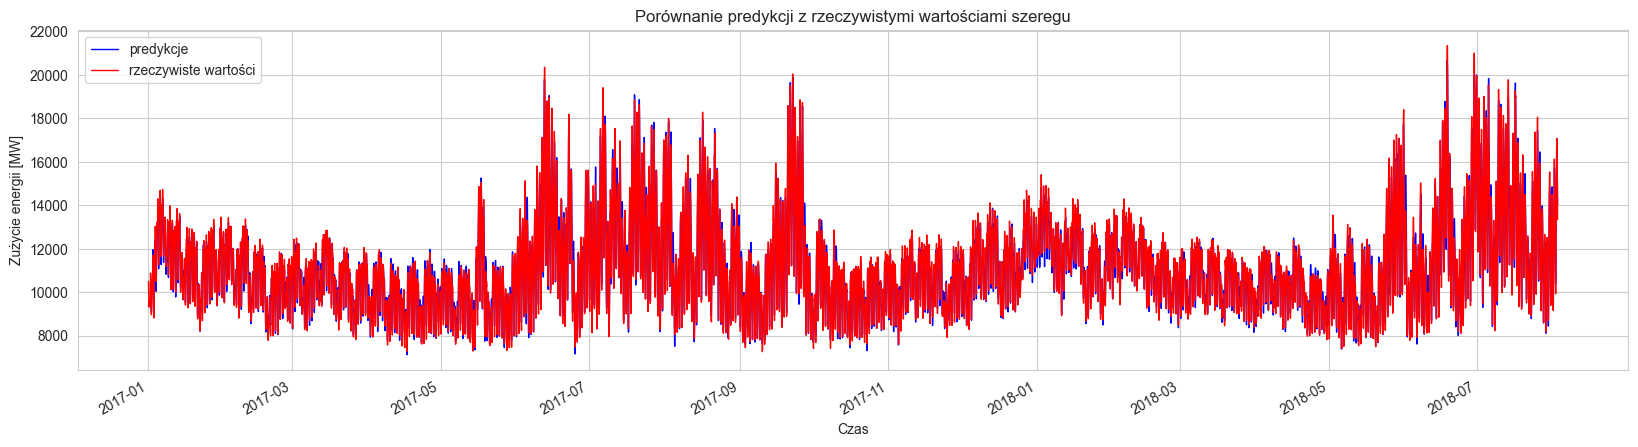

In [64]:
visualize_comparison(resulted_dataframe, test_set)

In [68]:
model = RNNModel(input_size=1, output_size=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 80
val_dataloader = DataLoader(
    TensorDataset(
        X_val, y_val
    ),
    shuffle=True,
    batch_size=64,
)
train(
    model=model, 
    optimizer=optimizer, 
    regression_loss=regression_loss, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    number_of_epochs=150, 
    model_name='RNNModel'
)

Epoka: 0, treningowe RMSE: 0.28729822724274484, walidacyjne RMSE: 0.28327869282746887.
Epoka: 10, treningowe RMSE: 0.18757241017167736, walidacyjne RMSE: 0.19976306304409777.
Epoka: 20, treningowe RMSE: 0.15461336156856104, walidacyjne RMSE: 0.1713289864142763.
Epoka: 30, treningowe RMSE: 0.15045193104633367, walidacyjne RMSE: 0.17170980116812015.
Epoka: 40, treningowe RMSE: 0.14285839412782594, walidacyjne RMSE: 0.16585318095791488.
Epoka: 50, treningowe RMSE: 0.13652269321214588, walidacyjne RMSE: 0.16342766650077983.
Epoka: 60, treningowe RMSE: 0.13798596170436522, walidacyjne RMSE: 0.16562456509156492.
Epoka: 70, treningowe RMSE: 0.13377072230025416, walidacyjne RMSE: 0.16210538790292275.
Epoka: 80, treningowe RMSE: 0.1292519749423811, walidacyjne RMSE: 0.16660065566025276.
Epoka: 90, treningowe RMSE: 0.1304539397881672, walidacyjne RMSE: 0.16983810297804686.
Epoka: 100, treningowe RMSE: 0.1294918132344459, walidacyjne RMSE: 0.16899223695196472.
Epoka: 110, treningowe RMSE: 0.12939

In [69]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.1870269626379013.


In [70]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00      9919.395508
1     2017-01-02 01:00:00      9546.428711
2     2017-01-02 02:00:00      9340.805664
3     2017-01-02 03:00:00      9148.825195
4     2017-01-02 04:00:00      8966.728516
...                   ...              ...
13866 2018-08-02 20:00:00     16045.193359
13867 2018-08-02 21:00:00     15409.078125
13868 2018-08-02 22:00:00     15058.667969
13869 2018-08-02 23:00:00     14521.085938
13870 2018-08-03 00:00:00     13366.523438

[13871 rows x 2 columns]


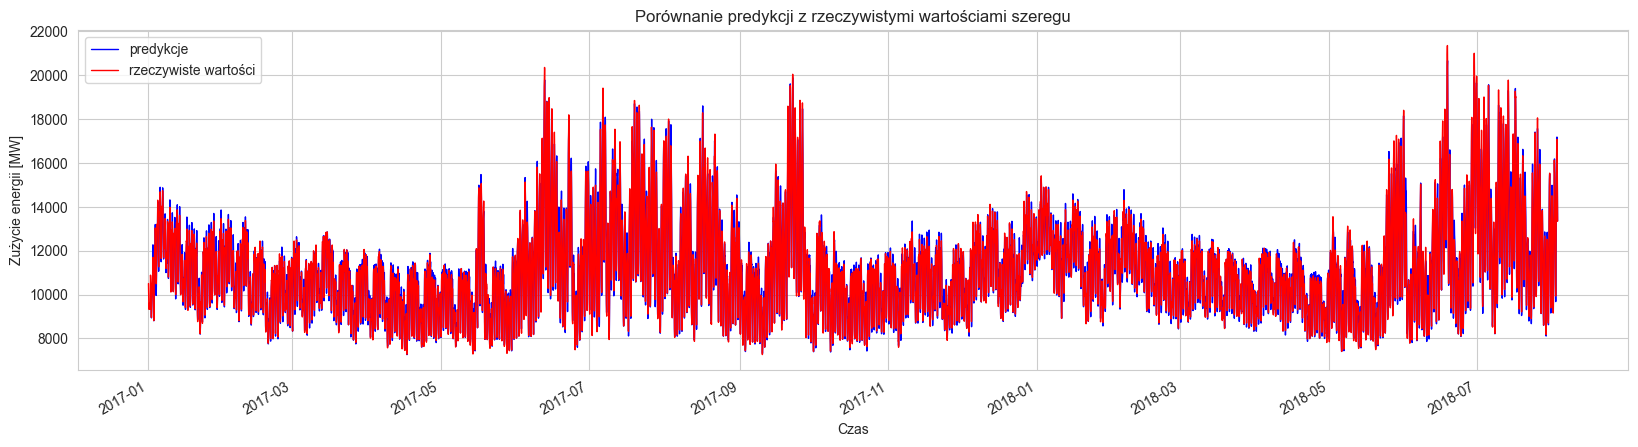

In [71]:
visualize_comparison(resulted_dataframe, test_set)